In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

/opt/anaconda3/envs/molgen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
# if lang_class_name.endswith("HELM"): #TODO: should be removed after .lang inclusion
#     lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.05, count_rollouts: 2, reward: 0.4362176369583748, node: O=C(OC[C@H](O)c1ccc(Cl)cc1Cl)N1C[C@H]2CCCC[C@@H]2CC1
1- time: 0.21, count_rollouts: 6, reward: 0.3304915709372697, node: [NH3+][C@H](c1ccccc1Cl)c1ccccc1Br
2- time: 0.24, count_rollouts: 7, reward: 0.43016571065366416, node: Clc1cc(F)ccc1[C@H]1CCN(c2cccc(OC(F)F)c2)C1=O
3- time: 0.30, count_rollouts: 8, reward: 0.3371646057322661, node: SC(=O)Nc1ccc(N2CCN(C(=O)c3cc(F)c(F)cc3)C2=O)cc1
4- time: 0.47, count_rollouts: 12, reward: 0.052272312266088805, node: [O-]c1ccc(NC(=O)CCNC(=O)C2CC2)cc1[N+](=O)[O-]
5- time: 0.85, count_rollouts: 21, reward: 0.21924038624009914, node: N#CCN(C(=O)c1ccccn1)C1CC(C(=O)N2CCCC2)CCC1
6- time: 1.10, count_rollouts: 26, reward: 0.16209842713920555, node: [C@@H]C(=O)CNC(=O)N[C@H](C)c1ccc(C)cc1
7- time: 1.20, count_rollouts: 29, reward: 0.09784594056117148, node: NC(=O)CN[C@H]1CCO[C@@H](c2ccccc2)C1
8- time: 1.43, count_rollouts: 34, reward: 0.3884811710728435, node: Cln1nc(CNC(=O)

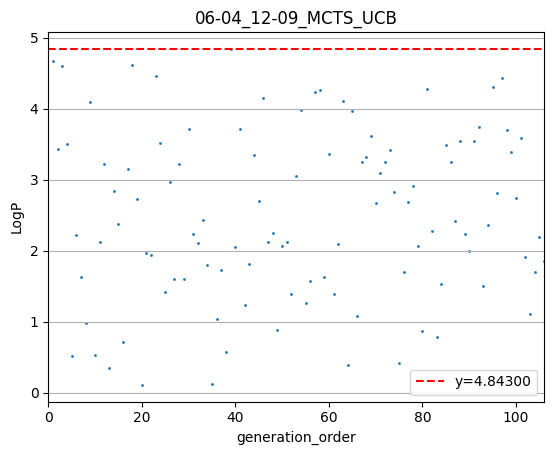

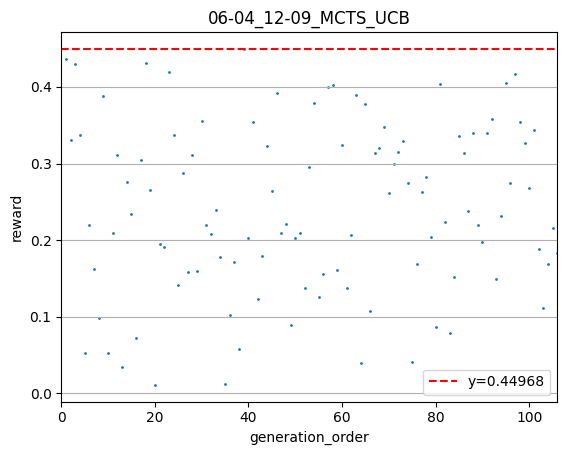

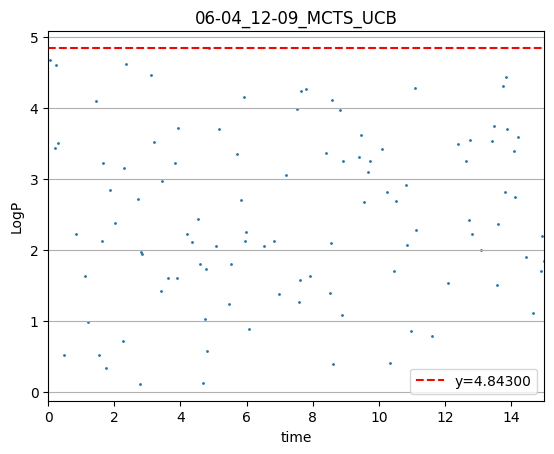

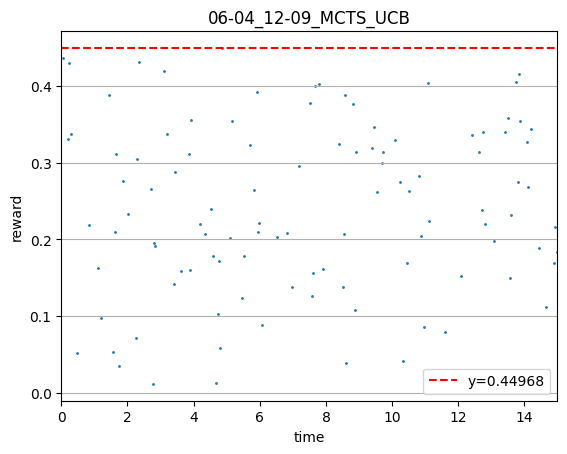

Search is completed.


In [10]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)